In [15]:
# Tristan Nguyen
# @author: tristan (NGUYEN VU ANH TRUNG)
# email = "kivanolai@gmail.com"
"""
Problem walkthrough
In this problem, you will build a classifier with loan_status as a binary target. 
In order to achieve that, you should only include loans that are either 'Fully Paid' (your 0’s) or
'Charged Off' (your 1’s).
- Download the dataset from
https://www.kaggle.com/datasets/ethon0426/lending-club-20072020q1
Note: Rename to .csv the .gzip file you will get after extracting once, and use it as a
regular csv file.
1. Run a quick analysis of the data and drop the grade, sub_grade, interest related
columns and any other columns you think may cause information leakage.
2. Propose at least two possible modeling approaches –including examples– based on
your analysis, expand on the various pros and cons.
3. Choose one of the above approaches and implement your classifier, evaluate your
model using one or more metrics you think are suited for the problem.
4. Explain (as in “explainability”) your model in terms of the classifier’s features.
5. Discuss additional steps you would take if you had more time or resources, and any
other datasets you could use to enrich your original dataset.
6. [OPTIONAL] Discuss the scalability of your solution, in terms of the
a. Number of loans/rows in the training data.
b. Number of predictions a possible inference endpoint for the model will be asked
to make in production.
7. [OPTIONAL] Find a way to relate your predictions to the local/global shape of the
dataset, that is, data point clusters, graph node communities, etc..
"""


In [1]:
%pip install numpy
%pip install polars

DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.11/site-packages/python_mnist-0.7-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
Note: you may need to restart the kernel to use updated packages.
DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.11/site-packages/python_mnist-0.7-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
Note: you may need to restart the kernel to use updated packages.


In [108]:
import numpy as np # linear algebra
import polars as pl

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../input/.DS_Store
../input/LCDataDictionary.xlsx
../input/Loan_status_2007-2020Q3.csv
../input/archive/.DS_Store


In [109]:
data_file_path  = "../input/Loan_status_2007-2020Q3.csv"
# Step 1: Load the data
# Load the data
# df = pl.scan_csv(data_file_path)
df = pl.read_csv(data_file_path,infer_schema_length=2000, null_values=["Loans that do not meet the credit policy"])

df.head()


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,…,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
i64,i64,i64,i64,f64,str,str,f64,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,f64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,str,…,str,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
0,1077501,5000,5000,4975.0,""" 36 months""",""" 10.65%""",162.87,"""B""","""B2""",null,"""10+ years""","""RENT""",24000.0,"""Verified""","""Dec-2011""","""Fully Paid""","""n""","""https://lendingclub.com/browse…","""credit_card""","""Computer""","""860xx""","""AZ""",27.65,0,"""Jan-1985""",735,739,1,null,null,3,0,13648,"""83.7%""",9,"""f""",…,null,null,null,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N"""
1,1077430,2500,2500,2500.0,""" 60 months""",""" 15.27%""",59.83,"""C""","""C4""","""Ryder""","""< 1 year""","""RENT""",30000.0,"""Source Verified""","""Dec-2011""","""Charged Off""","""n""","""https://lendingclub.com/browse…","""car""","""bike""","""309xx""","""GA""",1.0,0,"""Apr-1999""",740,744,5,null,null,3,0,1687,"""9.4%""",4,"""f""",…,null,null,null,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N"""
2,1077175,2400,2400,2400.0,""" 36 months""",""" 15.96%""",84.33,"""C""","""C5""",null,"""10+ years""","""RENT""",12252.0,"""Not Verified""","""Dec-2011""","""Fully Paid""","""n""","""https://lendingclub.com/browse…","""small_business""","""real estate business""","""606xx""","""IL""",8.72,0,"""Nov-2001""",735,739,2,null,null,2,0,2956,"""98.5%""",10,"""f""",…,null,null,null,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N"""
3,1076863,10000,10000,10000.0,""" 36 months""",""" 13.49%""",339.31,"""C""","""C1""","""AIR RESOURCES BOARD""","""10+ years""","""RENT""",49200.0,"""Source Verified""","""Dec-2011""","""Fully Paid""","""n""","""https://lendingclub.com/browse…","""other""","""personel""","""917xx""","""CA""",20.0,0,"""Feb-1996""",690,694,1,35,null,10,0,5598,"""21%""",37,"""f""",…,null,null,null,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N"""
4,1075358,3000,3000,3000.0,""" 60 months""",""" 12.69%""",67.79,"""B""","""B5""","""University Medical Group""","""1 year""","""RENT""",80000.0,"""Source Verified""","""Dec-2011""","""Fully Paid""","""n""","""https://lendingclub.com/browse…","""other""","""Personal""","""972xx""","""OR""",17.94,0,"""Jan-1996""",695,699,0,38,null,15,0,27783,"""53.9%""",38,"""f""",…,null,null,n

In [110]:
filtered_df = df.drop_nulls(subset=df.columns)

In [25]:
filtered_df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,…,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
i64,i64,i64,i64,f64,str,str,f64,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,f64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,str,…,str,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
12757,118309395,19200,19200,19200.0,""" 60 months""",""" 30.94%""",632.32,"""G""","""G4""","""Admissions coordinator ""","""2 years""","""MORTGAGE""",50000.0,"""Source Verified""","""Sep-2017""","""Current""","""n""","""https://lendingclub.com/browse…","""debt_consolidation""","""Debt consolidation""","""707xx""","""LA""",52.06,0,"""Feb-2005""",660,664,3,57,53,20,1,23041,"""70%""",48,"""w""",…,"""7""","""95.3""","""60""",1,0,"""422550""","""164560""","""24900""","""144179""","""42537""","""585""","""589""","""Feb-2005""","""3""","""2""","""24""","""83.8""","""5""","""19""","""0""","""1""","""Y""","""CVD19SKIP""","""INCOMECURT""","""ACTIVE""","""2""","""0""","""Apr-2020""","""Jun-2020""","""Apr-2020""","""2""","""0""","""ACTIVE""","""718.79""","""14038.19""","""632.32""","""N"""
20811,118325515,24000,24000,24000.0,""" 60 months""",""" 15.05%""",571.59,"""C""","""C4""","""Owner""","""< 1 year""","""RENT""",34000.0,"""Not Verified""","""Sep-2017""","""Late (31-120 days)""","""n""","""https://lendingclub.com/browse…","""debt_consolidation""","""Debt consolidation""","""925xx""","""CA""",35.51,5,"""Apr-1988""",700,704,1,18,111,14,1,2574,"""9.1%""",18,"""w""",…,"""5""","""61.1""","""0""",1,0,"""71152""","""27132""","""19600""","""42852""","""8603""","""655""","""659""","""Apr-1988""","""0""","""0""","""12""","""25.6""","""4""","""11""","""0""","""0""","""N""","""ST0650PV01""","""UNEMPLOYED""","""COMPLETE""","""3""","""571.59""","""Jan-2019""","""Mar-2019""","""Jan-2019""","""3""","""25""","""DELINQUENT""","""645.18111""","""17730.24""","""300.08""","""N"""
21509,119196780,15000,15000,15000.0,""" 60 months""",""" 13.59%""",345.85,"""C""","""C2""","""RN""","""< 1 year""","""MORTGAGE""",50000.0,"""Not Verified""","""Sep-2017""","""Current""","""n""","""https://lendingclub.com/browse…","""credit_card""","""Credit card refinancing""","""062xx""","""CT""",32.36,0,"""Jan-2003""",680,684,1,73,75,13,1,6107,"""38.4%""",42,"""w""",…,"""1""","""96.9""","""50""",1,0,"""244670""","""51909""","""5500""","""66570""","""16060""","""670""","""674""","""Dec-2000""","""2""","""4""","""12""","""45.4""","""2""","""29""","""0""","""0""","""Y""","""CVD19SKIP""","""INCOMECURT""","""ACTIVE""","""2""","""0""","""Apr-2020""","""Jun-2020""","""Apr-2020""","""2""","""0""","""ACTIVE""","""198.31""","""8771.92""","""345.85""","""N"""
22627,118339354,26000,26000,26000.0,""" 36 months""",""" 14.08%""",889.63,"""C""","""C3""","""Teacher""","""7 years""","""MORTGAGE""",65500.0,"""Verified""","""Sep-2017""","""Current""","""n"

In [111]:
# Step 2: Filter the data
filtered_df = df.filter(pl.col("loan_status").is_in(["Fully Paid", "Charged Off"]))


In [29]:
# Assuming filtered_df is already defined
filtered_df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,…,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
i64,i64,i64,i64,f64,str,str,f64,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,f64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,str,…,str,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
0,1077501,5000,5000,4975.0,""" 36 months""",""" 10.65%""",162.87,"""B""","""B2""",null,"""10+ years""","""RENT""",24000.0,"""Verified""","""Dec-2011""","""Fully Paid""","""n""","""https://lendingclub.com/browse…","""credit_card""","""Computer""","""860xx""","""AZ""",27.65,0,"""Jan-1985""",735,739,1,null,null,3,0,13648,"""83.7%""",9,"""f""",…,null,null,null,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N"""
1,1077430,2500,2500,2500.0,""" 60 months""",""" 15.27%""",59.83,"""C""","""C4""","""Ryder""","""< 1 year""","""RENT""",30000.0,"""Source Verified""","""Dec-2011""","""Charged Off""","""n""","""https://lendingclub.com/browse…","""car""","""bike""","""309xx""","""GA""",1.0,0,"""Apr-1999""",740,744,5,null,null,3,0,1687,"""9.4%""",4,"""f""",…,null,null,null,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N"""
2,1077175,2400,2400,2400.0,""" 36 months""",""" 15.96%""",84.33,"""C""","""C5""",null,"""10+ years""","""RENT""",12252.0,"""Not Verified""","""Dec-2011""","""Fully Paid""","""n""","""https://lendingclub.com/browse…","""small_business""","""real estate business""","""606xx""","""IL""",8.72,0,"""Nov-2001""",735,739,2,null,null,2,0,2956,"""98.5%""",10,"""f""",…,null,null,null,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N"""
3,1076863,10000,10000,10000.0,""" 36 months""",""" 13.49%""",339.31,"""C""","""C1""","""AIR RESOURCES BOARD""","""10+ years""","""RENT""",49200.0,"""Source Verified""","""Dec-2011""","""Fully Paid""","""n""","""https://lendingclub.com/browse…","""other""","""personel""","""917xx""","""CA""",20.0,0,"""Feb-1996""",690,694,1,35,null,10,0,5598,"""21%""",37,"""f""",…,null,null,null,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N"""
4,1075358,3000,3000,3000.0,""" 60 months""",""" 12.69%""",67.79,"""B""","""B5""","""University Medical Group""","""1 year""","""RENT""",80000.0,"""Source Verified""","""Dec-2011""","""Fully Paid""","""n""","""https://lendingclub.com/browse…","""other""","""Personal""","""972xx""","""OR""",17.94,0,"""Jan-1996""",695,699,0,38,null,15,0,27783,"""53.9%""",38,"""f""",…,null,null,n

In [32]:
# %pip install matplotlib
%pip install seaborn

DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.11/site-packages/python_mnist-0.7-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
Note: you may need to restart the kernel to use updated packages.


/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


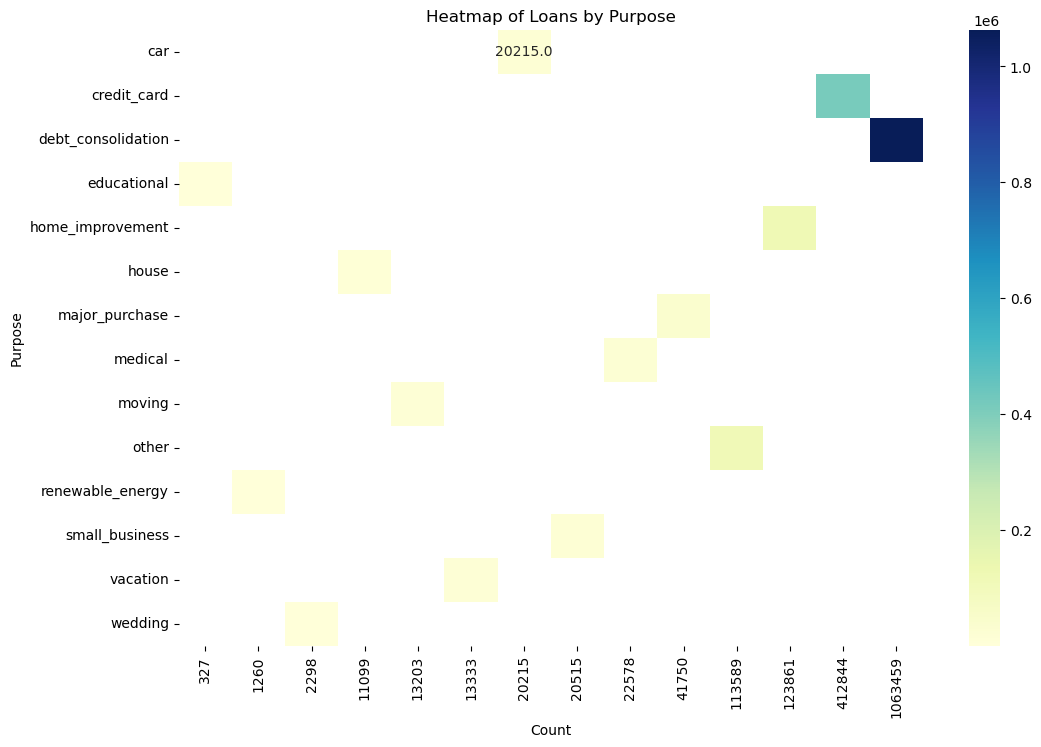

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming filtered_df is already defined and is a Polars DataFrame
# Convert Polars DataFrame to Pandas DataFrame
filtered_df_pd = filtered_df.to_pandas()

# Group by 'purpose' and count the occurrences
purpose_counts = filtered_df_pd.groupby('purpose').size().reset_index(name='count')

# Create a pivot table for the heatmap
heatmap_data = purpose_counts.pivot(index='purpose', columns='count', values='count')

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Heatmap of Loans by Purpose')
plt.xlabel('Count')
plt.ylabel('Purpose')
plt.show()

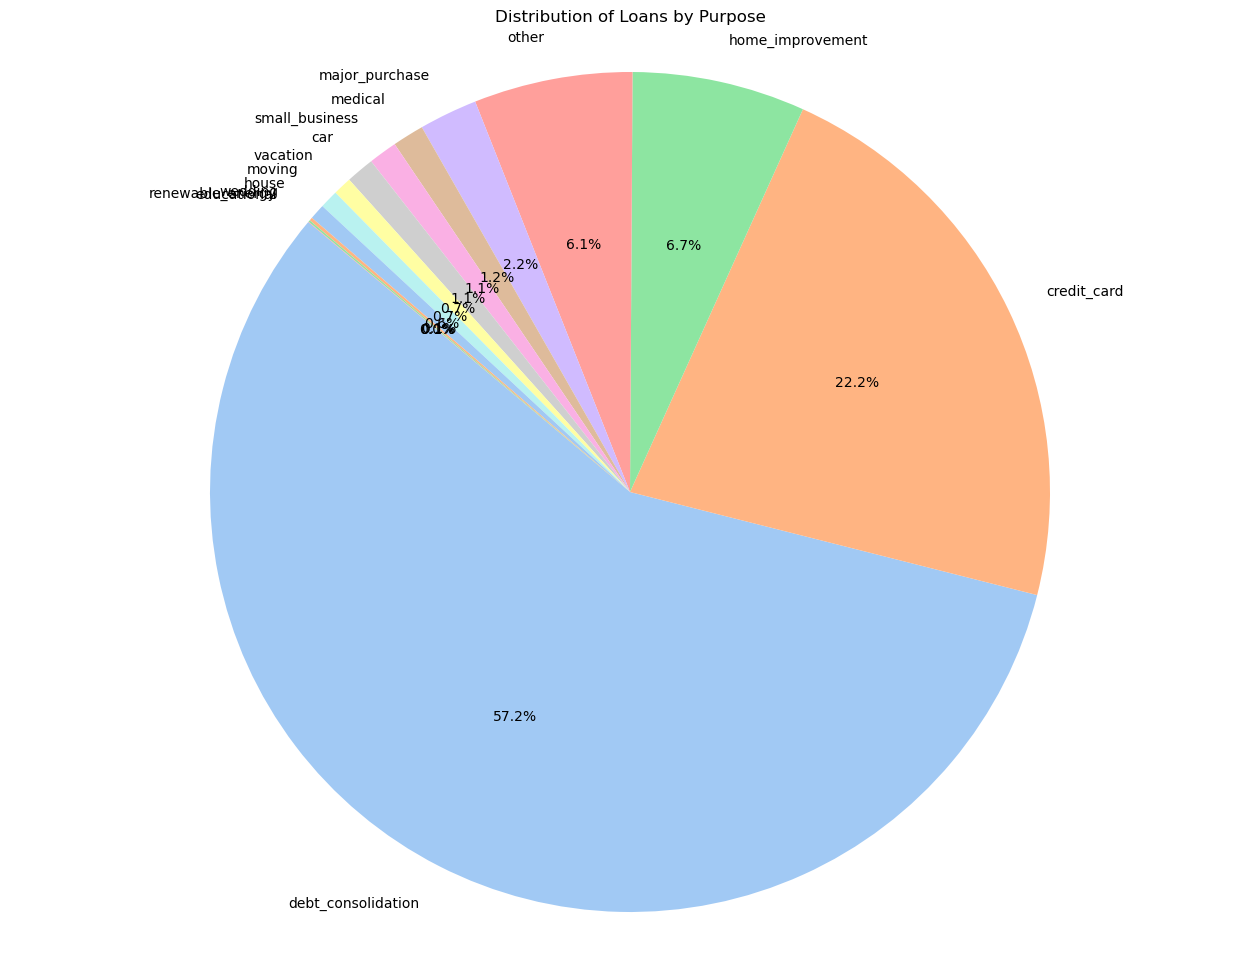

In [37]:
import matplotlib.pyplot as plt

# Assuming filtered_df_pd is already defined and is a Pandas DataFrame
# Group by 'purpose' and count the occurrences
purpose_counts = filtered_df_pd['purpose'].value_counts()

# Create a pie chart
plt.figure(figsize=(16, 12))
plt.pie(purpose_counts, labels=purpose_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title('Distribution of Loans by Purpose')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

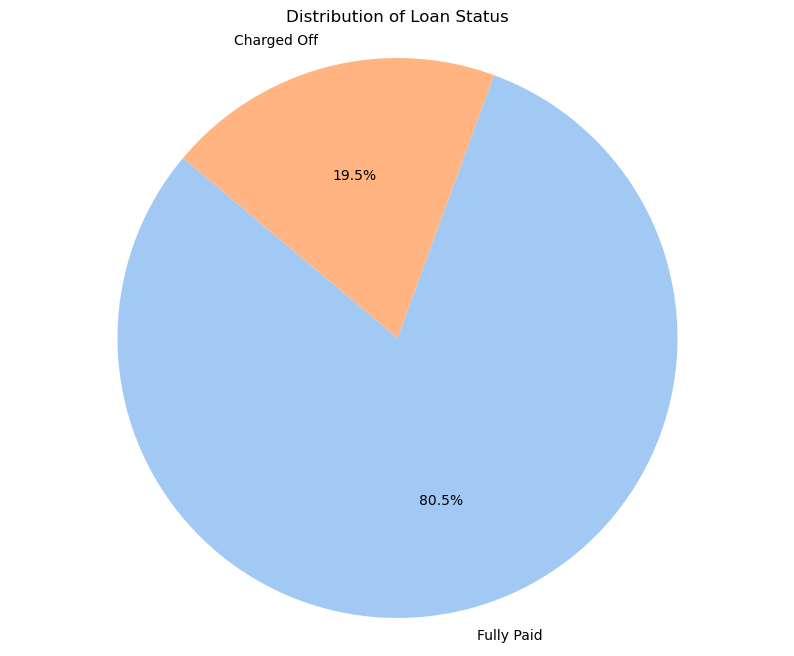

In [38]:
import matplotlib.pyplot as plt

# Assuming filtered_df_pd is already defined and is a Pandas DataFrame
# Group by 'loan_status' and count the occurrences
loan_status_counts = filtered_df_pd['loan_status'].value_counts()

# Create a pie chart
plt.figure(figsize=(10, 8))
plt.pie(loan_status_counts, labels=loan_status_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title('Distribution of Loan Status')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [112]:
filtered_df_pd['loan_status'].value_counts()

loan_status
Fully Paid     1497783
Charged Off     362548
Name: count, dtype: int64

In [113]:
filtered_df_pd['loan_status'].value_counts(normalize=True)

loan_status
Fully Paid     0.805116
Charged Off    0.194884
Name: proportion, dtype: float64

<Axes: xlabel='loan_status'>

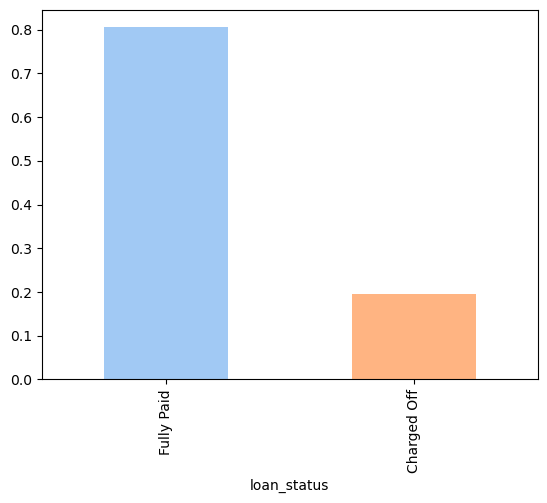

In [47]:
filtered_df_pd['loan_status'].value_counts(normalize=True).plot(kind='bar', color=sns.color_palette("pastel"))

In [44]:
filtered_df_pd.columns

Index(['', 'id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
       'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
       'hardship_length', 'hardship_dpd', 'hardship_loan_status',
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag'],
      dtype='object', length=142)

In [114]:
#  drop the grade, sub_grade, interest related
# columns and any other columns you think may cause information leakage.
# List of columns to drop
columns_to_drop = [
    'grade', 
    'sub_grade', 
    'int_rate', 
    'installment', 
    'out_prncp', 
    'out_prncp_inv', 
    'total_pymnt', 
    'total_pymnt_inv', 
    'total_rec_prncp', 
    'total_rec_int', 
    'total_rec_late_fee', 
    'recoveries', 
    'collection_recovery_fee', 
    'last_pymnt_d', 
    'last_pymnt_amnt'
]

droped_filtered_df = filtered_df.drop(columns_to_drop)

droped_filtered_df.columns

['',
 'id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_re

In [115]:
import polars as pl

# Assuming droped_filtered_df is already defined
# If not, load your dataset and drop the necessary columns as shown previously

# Summary statistics for the 'funded_amnt' column
summary_stats = droped_filtered_df.select([
    pl.col('funded_amnt').mean().alias('mean_funded_amnt'),
    pl.col('funded_amnt').median().alias('median_funded_amnt'),
    pl.col('funded_amnt').std().alias('std_funded_amnt'),
    pl.col('funded_amnt').min().alias('min_funded_amnt'),
    pl.col('funded_amnt').max().alias('max_funded_amnt')
])

print("Summary Statistics for 'funded_amnt':")
print(summary_stats)

# Group by 'funded_amnt' and count the number of occurrences
grouped_funded_amnt = droped_filtered_df.group_by('funded_amnt').agg([
    pl.len().alias('count')
])

print("Grouped by 'funded_amnt':")
print(grouped_funded_amnt)



Summary Statistics for 'funded_amnt':
shape: (1, 5)
┌──────────────────┬────────────────────┬─────────────────┬─────────────────┬─────────────────┐
│ mean_funded_amnt ┆ median_funded_amnt ┆ std_funded_amnt ┆ min_funded_amnt ┆ max_funded_amnt │
│ ---              ┆ ---                ┆ ---             ┆ ---             ┆ ---             │
│ f64              ┆ f64                ┆ f64             ┆ i64             ┆ i64             │
╞══════════════════╪════════════════════╪═════════════════╪═════════════════╪═════════════════╡
│ 14582.177231     ┆ 12000.0            ┆ 8967.822906     ┆ 500             ┆ 40000           │
└──────────────────┴────────────────────┴─────────────────┴─────────────────┴─────────────────┘
Grouped by 'funded_amnt':
shape: (1_568, 2)
┌─────────────┬───────┐
│ funded_amnt ┆ count │
│ ---         ┆ ---   │
│ i64         ┆ u32   │
╞═════════════╪═══════╡
│ 9700        ┆ 543   │
│ 23625       ┆ 77    │
│ 32125       ┆ 36    │
│ 20475       ┆ 164   │
│ 28725       ┆ 

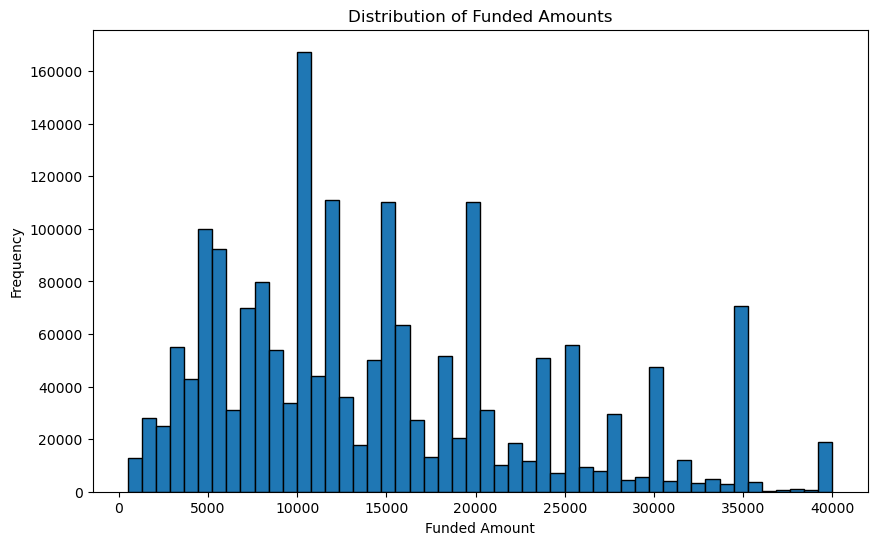

In [58]:
# Visualize the distribution of 'funded_amnt' values
import matplotlib.pyplot as plt

funded_amnt_pd = droped_filtered_df.select('funded_amnt')


plt.figure(figsize=(10, 6))
plt.hist(funded_amnt_pd['funded_amnt'], bins=50, edgecolor='k')
plt.title('Distribution of Funded Amounts')
plt.xlabel('Funded Amount')
plt.ylabel('Frequency')
plt.show()

## Approaches
To build a classifier with loan_status as a binary target ("Fully Paid" or "Charged Off"), here are two possible modeling approaches:

### Approach 1: Logistic Regression
#### Pros:
Simplicity: Logistic regression is straightforward to implement and interpret. 
Efficiency: It is computationally efficient and works well with large datasets.
Interpretability: The coefficients can be easily interpreted to understand the impact of each feature on the prediction.
Baseline Performance: Provides a good baseline performance for binary classification tasks.

#### Cons:
Linearity Assumption: Assumes a linear relationship between the features and the log-odds of the target variable, which may not always hold true.
Feature Engineering: Requires careful feature engineering and preprocessing (e.g., handling multicollinearity, scaling).
Limited Complexity: May not capture complex relationships in the data as well as more advanced models.

### Approach 2: Random Forest Classifier
#### Pros:
Non-linearity: Can capture complex, non-linear relationships between features and the target variable.
Feature Importance: Provides insights into feature importance, helping to understand which features contribute most to the predictions.
Robustness: Less prone to overfitting compared to individual decision trees due to the ensemble approach.
Versatility: Can handle a mix of numerical and categorical features without extensive preprocessing.
#### Cons:
Computationally Intensive: More computationally expensive and memory-intensive compared to logistic regression, especially with large datasets.
Interpretability: Less interpretable than logistic regression, as it is harder to understand the decision-making process of the ensemble of trees.
Hyperparameter Tuning: Requires careful tuning of hyperparameters (e.g., number of trees, max depth) to achieve optimal performance.

In [116]:
import polars as pl
import pandas as pd
import plotly.express as px
# Evaluate the distribution of the "term" column
term_distribution = droped_filtered_df['term'].value_counts()

# Display the distribution
print("Term Value Distribution:")
print(term_distribution)

# Display descriptive statistics
term_stats = droped_filtered_df['term'].describe()
print("\nTerm Descriptive Statistics:")
print(term_stats)

Term Value Distribution:
shape: (2, 2)
┌────────────┬─────────┐
│ term       ┆ count   │
│ ---        ┆ ---     │
│ str        ┆ u32     │
╞════════════╪═════════╡
│  60 months ┆ 467032  │
│  36 months ┆ 1393299 │
└────────────┴─────────┘

Term Descriptive Statistics:
shape: (4, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ str        │
╞════════════╪════════════╡
│ count      ┆ 1860331    │
│ null_count ┆ 0          │
│ min        ┆  36 months │
│ max        ┆  60 months │
└────────────┴────────────┘


In [127]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming droped_filtered_df is already a Polars DataFrame
# Ensure 'term' column is cleaned and converted to numeric
term_distribution_droped_filtered_df = droped_filtered_df.with_columns(
    pl.col("term").str.replace('months', '').str.strip_chars().str.to_integer(base=10, strict=True)
)


# Evaluate the distribution of the "term" column
term_distribution = term_distribution_droped_filtered_df['term'].value_counts()

# Display the distribution
print("Term Value Distribution:")
print(term_distribution)

Term Value Distribution:
shape: (2, 2)
┌──────┬─────────┐
│ term ┆ count   │
│ ---  ┆ ---     │
│ i64  ┆ u32     │
╞══════╪═════════╡
│ 60   ┆ 467032  │
│ 36   ┆ 1393299 │
└──────┴─────────┘


In [128]:
term_distribution_droped_filtered_df

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,…,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
i64,i64,i64,i64,f64,i64,str,str,str,f64,str,str,str,str,str,str,str,str,str,f64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,str,str,str,i64,i64,…,str,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
0,1077501,5000,5000,4975.0,36,null,"""10+ years""","""RENT""",24000.0,"""Verified""","""Dec-2011""","""Fully Paid""","""n""","""https://lendingclub.com/browse…","""credit_card""","""Computer""","""860xx""","""AZ""",27.65,0,"""Jan-1985""",735,739,1,null,null,3,0,13648,"""83.7%""",9,"""f""",null,"""May-2020""",704,700,…,null,null,null,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N"""
1,1077430,2500,2500,2500.0,60,"""Ryder""","""< 1 year""","""RENT""",30000.0,"""Source Verified""","""Dec-2011""","""Charged Off""","""n""","""https://lendingclub.com/browse…","""car""","""bike""","""309xx""","""GA""",1.0,0,"""Apr-1999""",740,744,5,null,null,3,0,1687,"""9.4%""",4,"""f""",null,"""Oct-2016""",499,0,…,null,null,null,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N"""
2,1077175,2400,2400,2400.0,36,null,"""10+ years""","""RENT""",12252.0,"""Not Verified""","""Dec-2011""","""Fully Paid""","""n""","""https://lendingclub.com/browse…","""small_business""","""real estate business""","""606xx""","""IL""",8.72,0,"""Nov-2001""",735,739,2,null,null,2,0,2956,"""98.5%""",10,"""f""",null,"""Jun-2017""",739,735,…,null,null,null,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N"""
3,1076863,10000,10000,10000.0,36,"""AIR RESOURCES BOARD""","""10+ years""","""RENT""",49200.0,"""Source Verified""","""Dec-2011""","""Fully Paid""","""n""","""https://lendingclub.com/browse…","""other""","""personel""","""917xx""","""CA""",20.0,0,"""Feb-1996""",690,694,1,35,null,10,0,5598,"""21%""",37,"""f""",null,"""Apr-2016""",604,600,…,null,null,null,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N"""
4,1075358,3000,3000,3000.0,60,"""University Medical Group""","""1 year""","""RENT""",80000.0,"""Source Verified""","""Dec-2011""","""Fully Paid""","""n""","""https://lendingclub.com/browse…","""other""","""Personal""","""972xx""","""OR""",17.94,0,"""Jan-1996""",695,699,0,38,null,15,0,27783,"""53.9%""",38,"""f""",null,"""Apr-2018""",684,680,…,null,null,null,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,

## Loan status mapping : 
### "Charged Off" = True
### "Fully Paid" = False

In [129]:
import polars as pl
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Assuming `droped_filtered_df` is your Polars DataFrame
# Convert `loan_status` to binary values
loan_status_df = term_distribution_droped_filtered_df.with_columns(
    pl.when(pl.col("loan_status") == "Charged Off").then(1).otherwise(0).alias("loan_status")
)

# Ensure that the DataFrame is not empty and has the correct columns
if loan_status_df.is_empty():
    raise ValueError("The DataFrame is empty after filtering and conversion.")


In [132]:
loan_status_df

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,…,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
i64,i64,i64,i64,f64,i64,str,str,str,f64,str,str,i32,str,str,str,str,str,str,f64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,str,str,str,i64,i64,…,str,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
0,1077501,5000,5000,4975.0,36,null,"""10+ years""","""RENT""",24000.0,"""Verified""","""Dec-2011""",0,"""n""","""https://lendingclub.com/browse…","""credit_card""","""Computer""","""860xx""","""AZ""",27.65,0,"""Jan-1985""",735,739,1,null,null,3,0,13648,"""83.7%""",9,"""f""",null,"""May-2020""",704,700,…,null,null,null,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N"""
1,1077430,2500,2500,2500.0,60,"""Ryder""","""< 1 year""","""RENT""",30000.0,"""Source Verified""","""Dec-2011""",1,"""n""","""https://lendingclub.com/browse…","""car""","""bike""","""309xx""","""GA""",1.0,0,"""Apr-1999""",740,744,5,null,null,3,0,1687,"""9.4%""",4,"""f""",null,"""Oct-2016""",499,0,…,null,null,null,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N"""
2,1077175,2400,2400,2400.0,36,null,"""10+ years""","""RENT""",12252.0,"""Not Verified""","""Dec-2011""",0,"""n""","""https://lendingclub.com/browse…","""small_business""","""real estate business""","""606xx""","""IL""",8.72,0,"""Nov-2001""",735,739,2,null,null,2,0,2956,"""98.5%""",10,"""f""",null,"""Jun-2017""",739,735,…,null,null,null,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N"""
3,1076863,10000,10000,10000.0,36,"""AIR RESOURCES BOARD""","""10+ years""","""RENT""",49200.0,"""Source Verified""","""Dec-2011""",0,"""n""","""https://lendingclub.com/browse…","""other""","""personel""","""917xx""","""CA""",20.0,0,"""Feb-1996""",690,694,1,35,null,10,0,5598,"""21%""",37,"""f""",null,"""Apr-2016""",604,600,…,null,null,null,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N"""
4,1075358,3000,3000,3000.0,60,"""University Medical Group""","""1 year""","""RENT""",80000.0,"""Source Verified""","""Dec-2011""",0,"""n""","""https://lendingclub.com/browse…","""other""","""Personal""","""972xx""","""OR""",17.94,0,"""Jan-1996""",695,699,0,38,null,15,0,27783,"""53.9%""",38,"""f""",null,"""Apr-2018""",684,680,…,null,null,null,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,nul

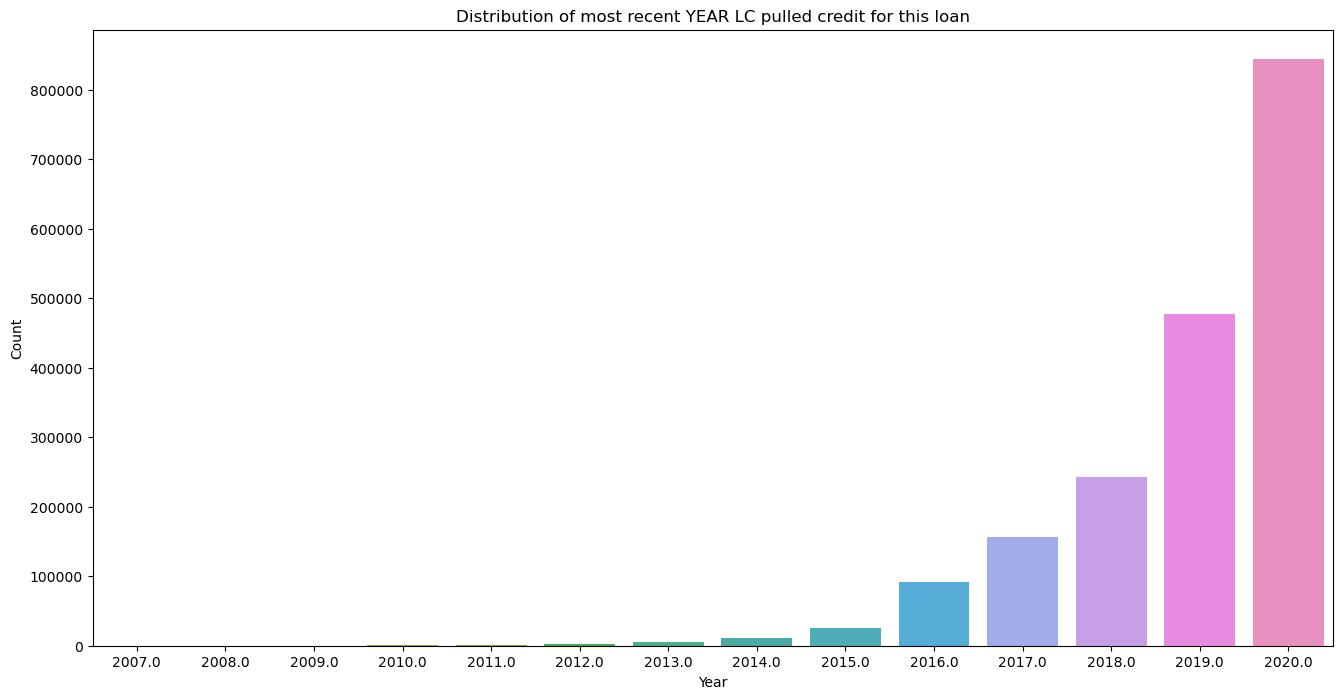

In [156]:
import matplotlib.pyplot as plt
import seaborn

# Assuming droped_filtered_df is already defined
# Convert 'last_credit_pull_d' to a year
loan_status_df = loan_status_df.with_columns(
    pl.col('last_credit_pull_d').str.slice(-4).str.to_integer(base=10, strict=True).alias('last_credit_pull_d')
)

# Group by year and count the occurrences
last_credit_pull_d_counts = loan_status_df.group_by('last_credit_pull_d').agg([
    pl.len().alias('count')
])

# Convert to Pandas DataFrame for plotting
last_credit_pull_d_counts_pd = last_credit_pull_d_counts.to_pandas()

# Create a bar plot
plt.figure(figsize=(16, 8))
seaborn.barplot(x='last_credit_pull_d', y='count', data=last_credit_pull_d_counts_pd)
plt.title('Distribution of most recent YEAR LC pulled credit for this loan')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()



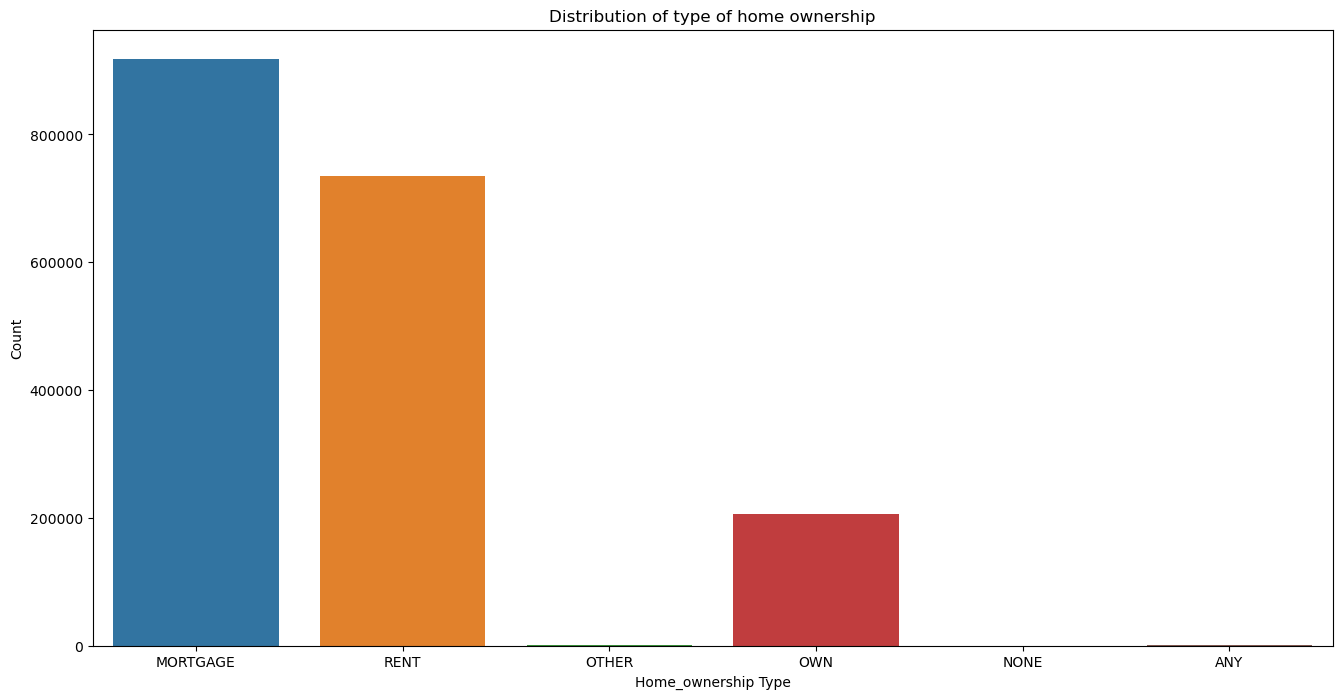

In [251]:
# home_ownership_df
# Assuming home_ownership_df is already defined
home_ownership_df = loan_status_df.with_columns(
    pl.col('home_ownership')
)

# Group by home_ownership and count the occurrences
home_ownership_df_counts = home_ownership_df.group_by('home_ownership').agg([
    pl.len().alias('count')
])

# Convert to Pandas DataFrame for plotting
home_ownership_df_counts_pd = home_ownership_df_counts.to_pandas()

# Create a bar plot
plt.figure(figsize=(16, 8))
seaborn.barplot(x='home_ownership', y='count', data=home_ownership_df_counts_pd)
plt.title('Distribution of type of home ownership')
plt.xlabel('Home_ownership Type')
plt.ylabel('Count')
plt.show()

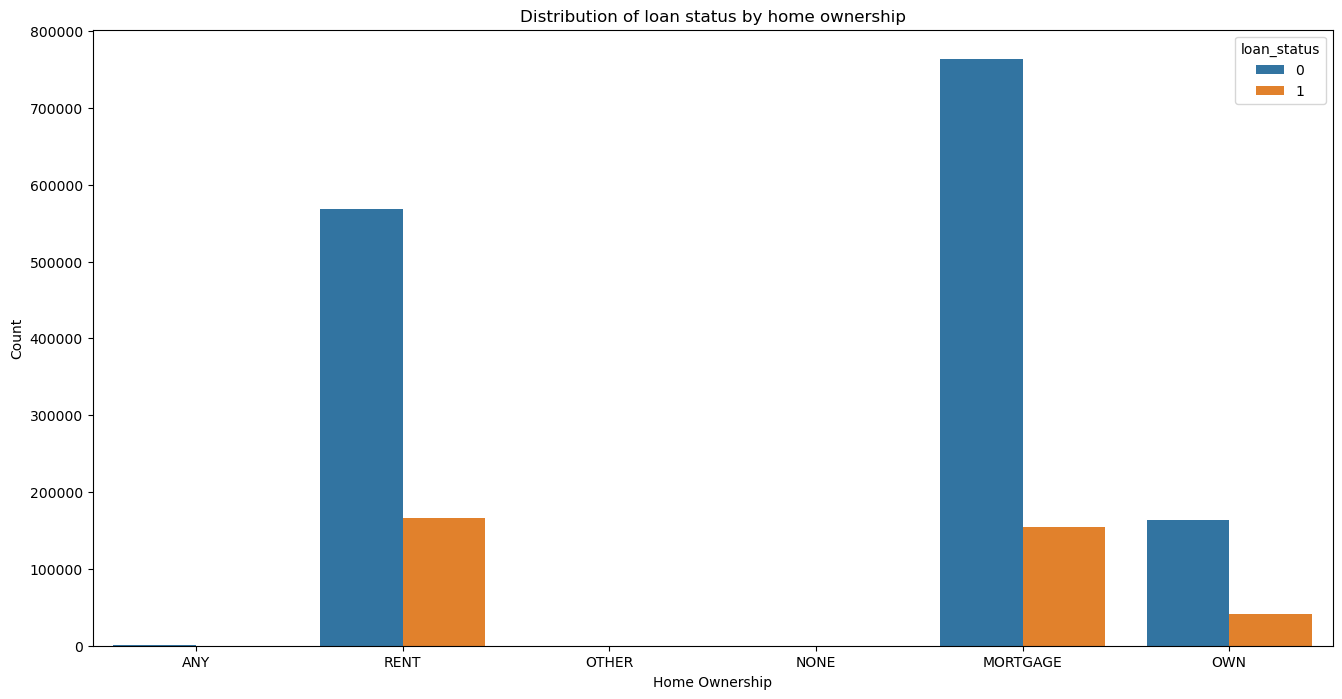

In [160]:
# home_ownership_df

# Assuming home_ownership_df is already defined
# classify correlation of home_ownership with loan_status
home_ownership_loan_status = home_ownership_df.group_by(['home_ownership', 'loan_status']).agg([
    pl.len().alias('count')
])

# Convert to Pandas DataFrame for plotting
home_ownership_loan_status_pd = home_ownership_loan_status.to_pandas()

# Create a bar plot
plt.figure(figsize=(16, 8))
seaborn.barplot(x='home_ownership', y='count', hue='loan_status', data=home_ownership_loan_status_pd)
plt.title('Distribution of loan status by home ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.show()


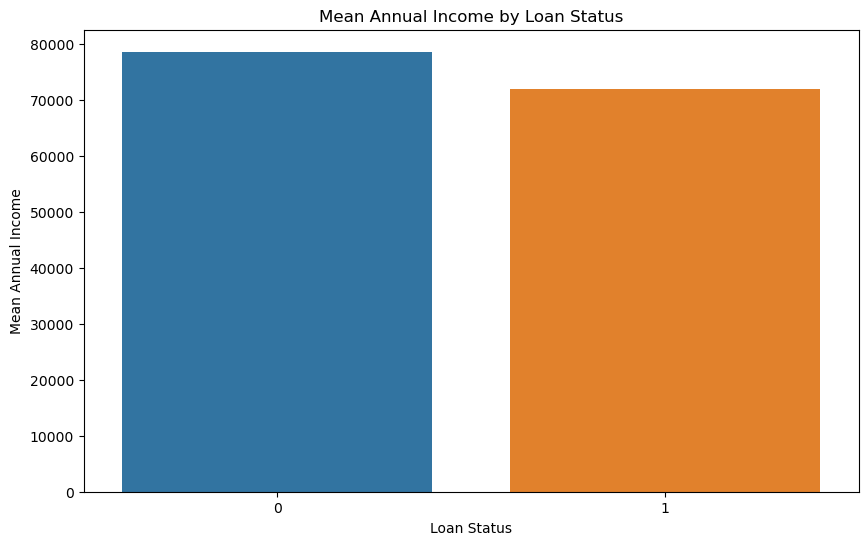

In [162]:
# explore the relationship between 'loan_status' and 'annual_inc' and 'dti' and 'funded_amnt'
# Assuming loan_status_df is already defined
# Convert 'annual_inc' to float

# Group by 'loan_status' and calculate the mean of 'annual_inc'
annual_inc_loan_status = loan_status_df.group_by('loan_status').agg([
    pl.mean('annual_inc').alias('mean_annual_inc')
])

# Convert to Pandas DataFrame for plotting
annual_inc_loan_status_pd = annual_inc_loan_status.to_pandas()

# Create a bar plot
plt.figure(figsize=(10, 6))
seaborn.barplot(x='loan_status', y='mean_annual_inc', data=annual_inc_loan_status_pd)
plt.title('Mean Annual Income by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Mean Annual Income')
plt.show()



In [222]:
loan_status_df_pd = loan_status_df.to_pandas()


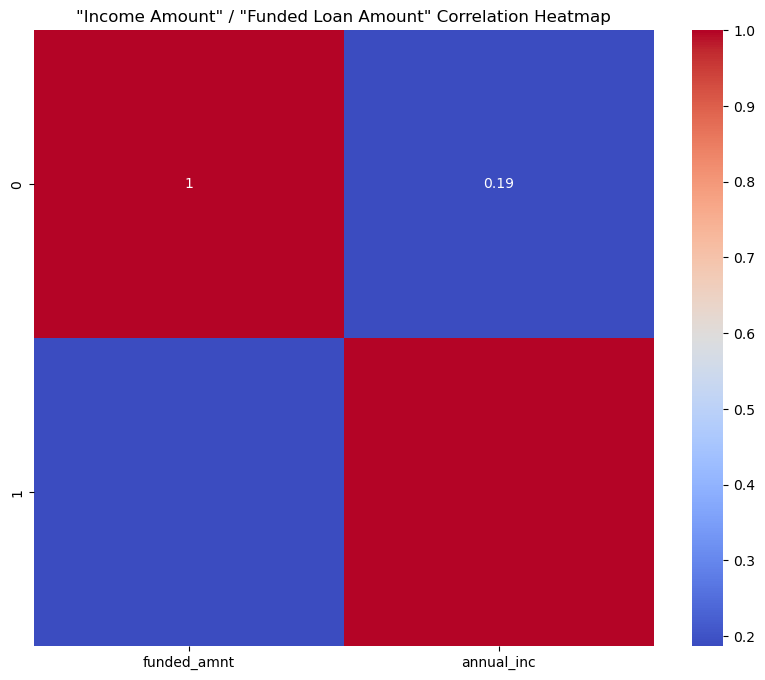

In [250]:

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Convert to Pandas DataFrame for plotting
correlation_matrix_pd = correlation_matrix.to_pandas()

# Create a heatmap
plt.figure(figsize=(10, 8))
seaborn.heatmap(correlation_matrix_pd, annot=True, cmap='coolwarm')
plt.title('"Income Amount" / "Funded Loan Amount" Correlation Heatmap')
plt.show()

In [224]:
loan_status_df_pd

,,id,loan_amnt,funded_amnt,funded_amnt_inv,term,emp_title,emp_length,home_ownership,annual_inc,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,0,1077501,5000,5000,4975.0,36,None,10+ years,RENT,24000.0,...,None,None,None,None,None,None,None,None,None,N
1,1,1077430,2500,2500,2500.0,60,Ryder,< 1 year,RENT,30000.0,...,None,None,None,None,None,None,None,None,None,N
2,2,1077175,2400,2400,2400.0,36,None,10+ years,RENT,12252.0,...,None,None,None,None,None,None,None,None,None,N
3,3,1076863,10000,10000,10000.0,36,AIR RESOURCES BOARD,10+ years,RENT,49200.0,...,None,None,None,None,None,None,None,None,None,N
4,4,1075358,3000,3000,3000.0,60,University Medical Group,1 year,RENT,80000.0,...,None,None,None,None,None,None,None,None,None,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860326,105446,102556443,24000,24000,24000.0,60,Senior Escrow Officer,< 1 year,RENT,107000.0,...,None,None,None,None,None,None,None,None,None,N
1860327,105447,102653304,10000,10000,10000.0,36,Rn,10+ years,MORTGAGE,65000.0,...,None,None,None,None,None,None,None,None,None,N
1860328,105448,102628603,10050,10050,10050.0,36,Sales Associate,8 years,RENT,37000.0,...,None,None,None,None,None,None,None,None,None,N
1860329,105449,102196576,6000,6000,6000.0,36,Contact input,5 years,RENT,41000.0,...,None,None,None,None,None,None,None,None,None,N


In [225]:

# Convert columns to numeric and handle errors
loan_status_df_pd['dti'] = pd.to_numeric(loan_status_df_pd['dti'], errors='coerce')
loan_status_df_pd['annual_inc'] = pd.to_numeric(loan_status_df_pd['annual_inc'], errors='coerce')
loan_status_df_pd['funded_amnt'] = pd.to_numeric(loan_status_df_pd['funded_amnt'], errors='coerce')


In [236]:
# Encode categorical variables
loan_status_df_pd = pd.get_dummies(loan_status_df_pd, columns=['home_ownership'], drop_first=True)

In [237]:
loan_status_df_pd

,,id,loan_amnt,funded_amnt,funded_amnt_inv,term,emp_title,emp_length,annual_inc,verification_status,...,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,0,1077501,5000,5000,4975.0,36,None,10+ years,24000.0,Verified,...,None,None,None,None,N,False,False,False,False,True
1,1,1077430,2500,2500,2500.0,60,Ryder,< 1 year,30000.0,Source Verified,...,None,None,None,None,N,False,False,False,False,True
2,2,1077175,2400,2400,2400.0,36,None,10+ years,12252.0,Not Verified,...,None,None,None,None,N,False,False,False,False,True
3,3,1076863,10000,10000,10000.0,36,AIR RESOURCES BOARD,10+ years,49200.0,Source Verified,...,None,None,None,None,N,False,False,False,False,True
4,4,1075358,3000,3000,3000.0,60,University Medical Group,1 year,80000.0,Source Verified,...,None,None,None,None,N,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860326,105446,102556443,24000,24000,24000.0,60,Senior Escrow Officer,< 1 year,107000.0,Source Verified,...,None,None,None,None,N,False,False,False,False,True
1860327,105447,102653304,10000,10000,10000.0,36,Rn,10+ years,65000.0,Source Verified,...,None,None,None,None,N,True,False,False,False,False
1860328,105448,102628603,10050,10050,10050.0,36,Sales Associate,8 years,37000.0,Not Verified,...,None,None,None,None,N,False,False,False,False,True
1860329,105449,102196576,6000,6000,6000.0,36,Contact input,5 years,41000.0,Source Verified,...,None,None,None,None,N,False,False,False,False,True


In [238]:
# Split the dataset into features and target variable
X = loan_status_df_pd.drop('loan_status', axis=1)
y = loan_status_df_pd['loan_status']


In [227]:
y

0          0
1          1
2          0
3          0
4          0
          ..
1860326    1
1860327    0
1860328    1
1860329    0
1860330    1
Name: loan_status, Length: 1860331, dtype: int32

In [252]:
loan_status_df_pd.keys()

Index(['', 'id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
       'emp_title', 'emp_length', 'annual_inc', 'verification_status',
       ...
       'hardship_loan_status', 'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag', 'home_ownership_MORTGAGE',
       'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT'],
      dtype='object', length=131)

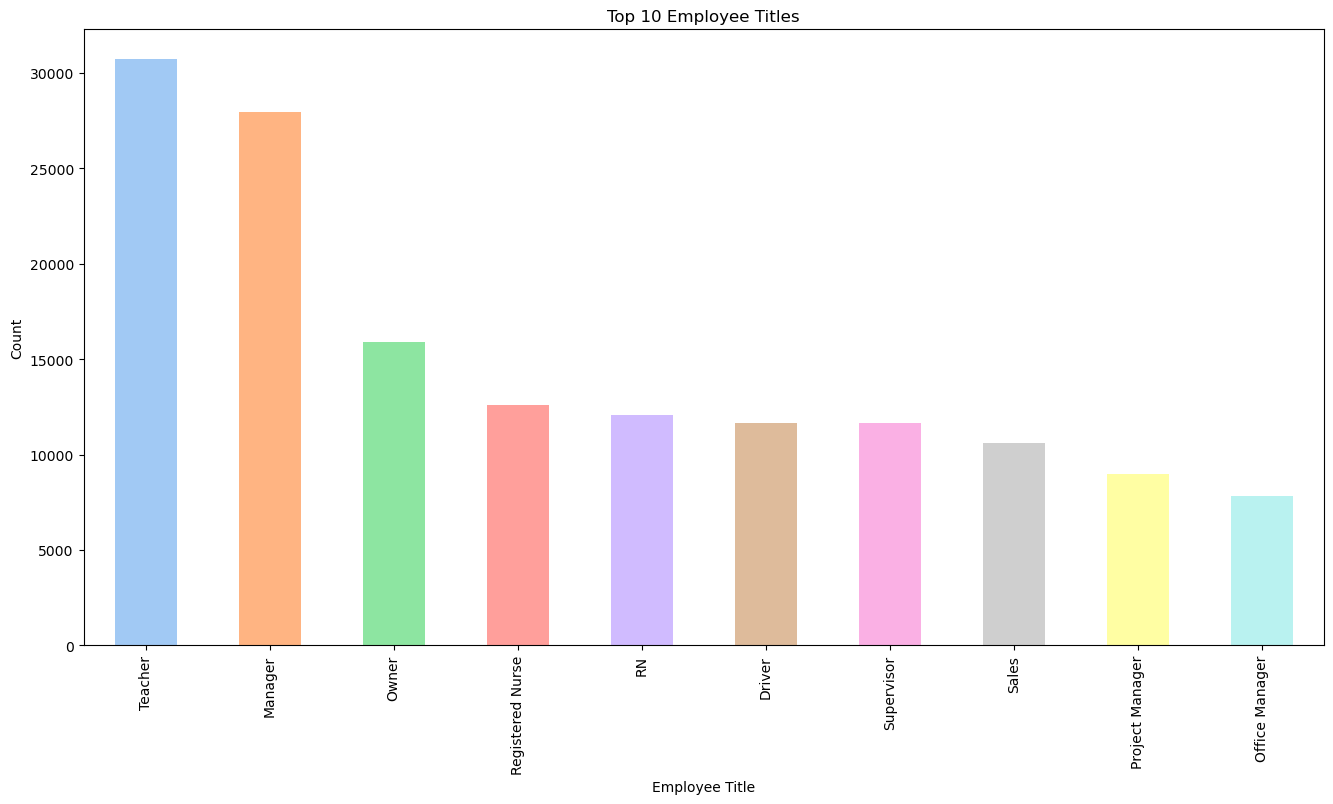

In [248]:
# draw distribution of emp_title
import matplotlib.pyplot as plt

# Assuming loan_status_df_pd is already defined
# Group by 'emp_title' and count the occurrences
emp_title_counts = loan_status_df_pd['emp_title'].value_counts()

# Create a bar plot
plt.figure(figsize=(16, 8))
emp_title_counts[:10].plot(kind='bar', color=sns.color_palette("pastel"))
plt.title('Top 10 Employee Titles')
plt.xlabel('Employee Title')
plt.ylabel('Count')
plt.show()



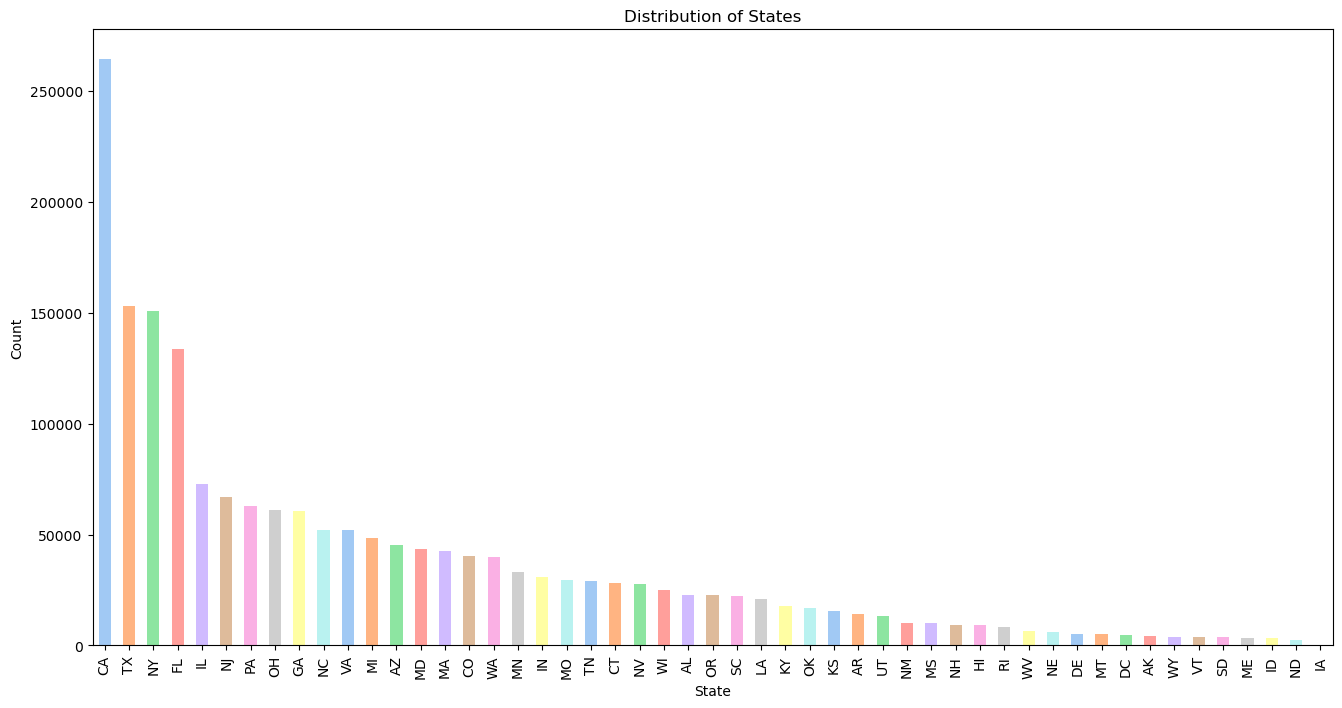

In [254]:

# loan_status_df_pd.correlation_matrix()

# draw distribution of State
import matplotlib.pyplot as plt

# Assuming loan_status_df_pd is already defined
# Group by 'addr_state' and count the occurrences
addr_state_counts = loan_status_df_pd['addr_state'].value_counts()

# Create a bar plot
plt.figure(figsize=(16, 8))
addr_state_counts.plot(kind='bar', color=sns.color_palette("pastel"))
plt.title('Distribution of States')
plt.xlabel('State')
plt.ylabel('Count')
plt.show()


In [259]:
loan_status_df_pd.keys()

Index(['', 'id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
       'emp_title', 'emp_length', 'annual_inc', 'verification_status',
       ...
       'hardship_loan_status', 'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag', 'home_ownership_MORTGAGE',
       'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT'],
      dtype='object', length=131)

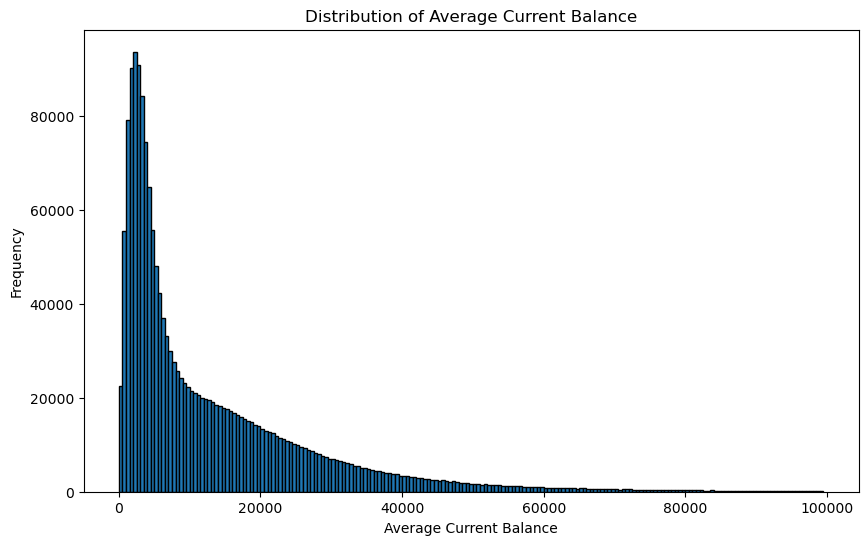

In [263]:
# find "avg_cur_bal" distribution histogram
import matplotlib.pyplot as plt

# Assuming loan_status_df_pd is already defined
# Convert 'avg_cur_bal' to float
loan_status_df_pd['avg_cur_bal'] = pd.to_numeric(loan_status_df_pd['avg_cur_bal'], errors='coerce')

# Drop missing values
avg_cur_bal_df = loan_status_df_pd.dropna(subset=['avg_cur_bal'])

# print all values of 'avg_cur_bal'
# group the values into bins of 1000
plt.figure(figsize=(10, 6))
plt.hist(avg_cur_bal_df['avg_cur_bal'], bins=range(0, 100000, 500), edgecolor='k')

plt.title('Distribution of Average Current Balance in Bins of 500$')
plt.xlabel('Average Current Balance')
plt.ylabel('Frequency')
plt.show()



In [239]:
import polars as pl
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)



In [240]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



ValueError: could not convert string to float: 'Regional Underwriting Manager'

## 3. approaches and implement classifier:
### I choose gradient boosted trees, evaluate my model